Saving img1.png to img1.png
Saving img2.png to img2.png
Saving img3.png to img3.png
Saving img4.png to img4.png
Saving img5.png to img5.png


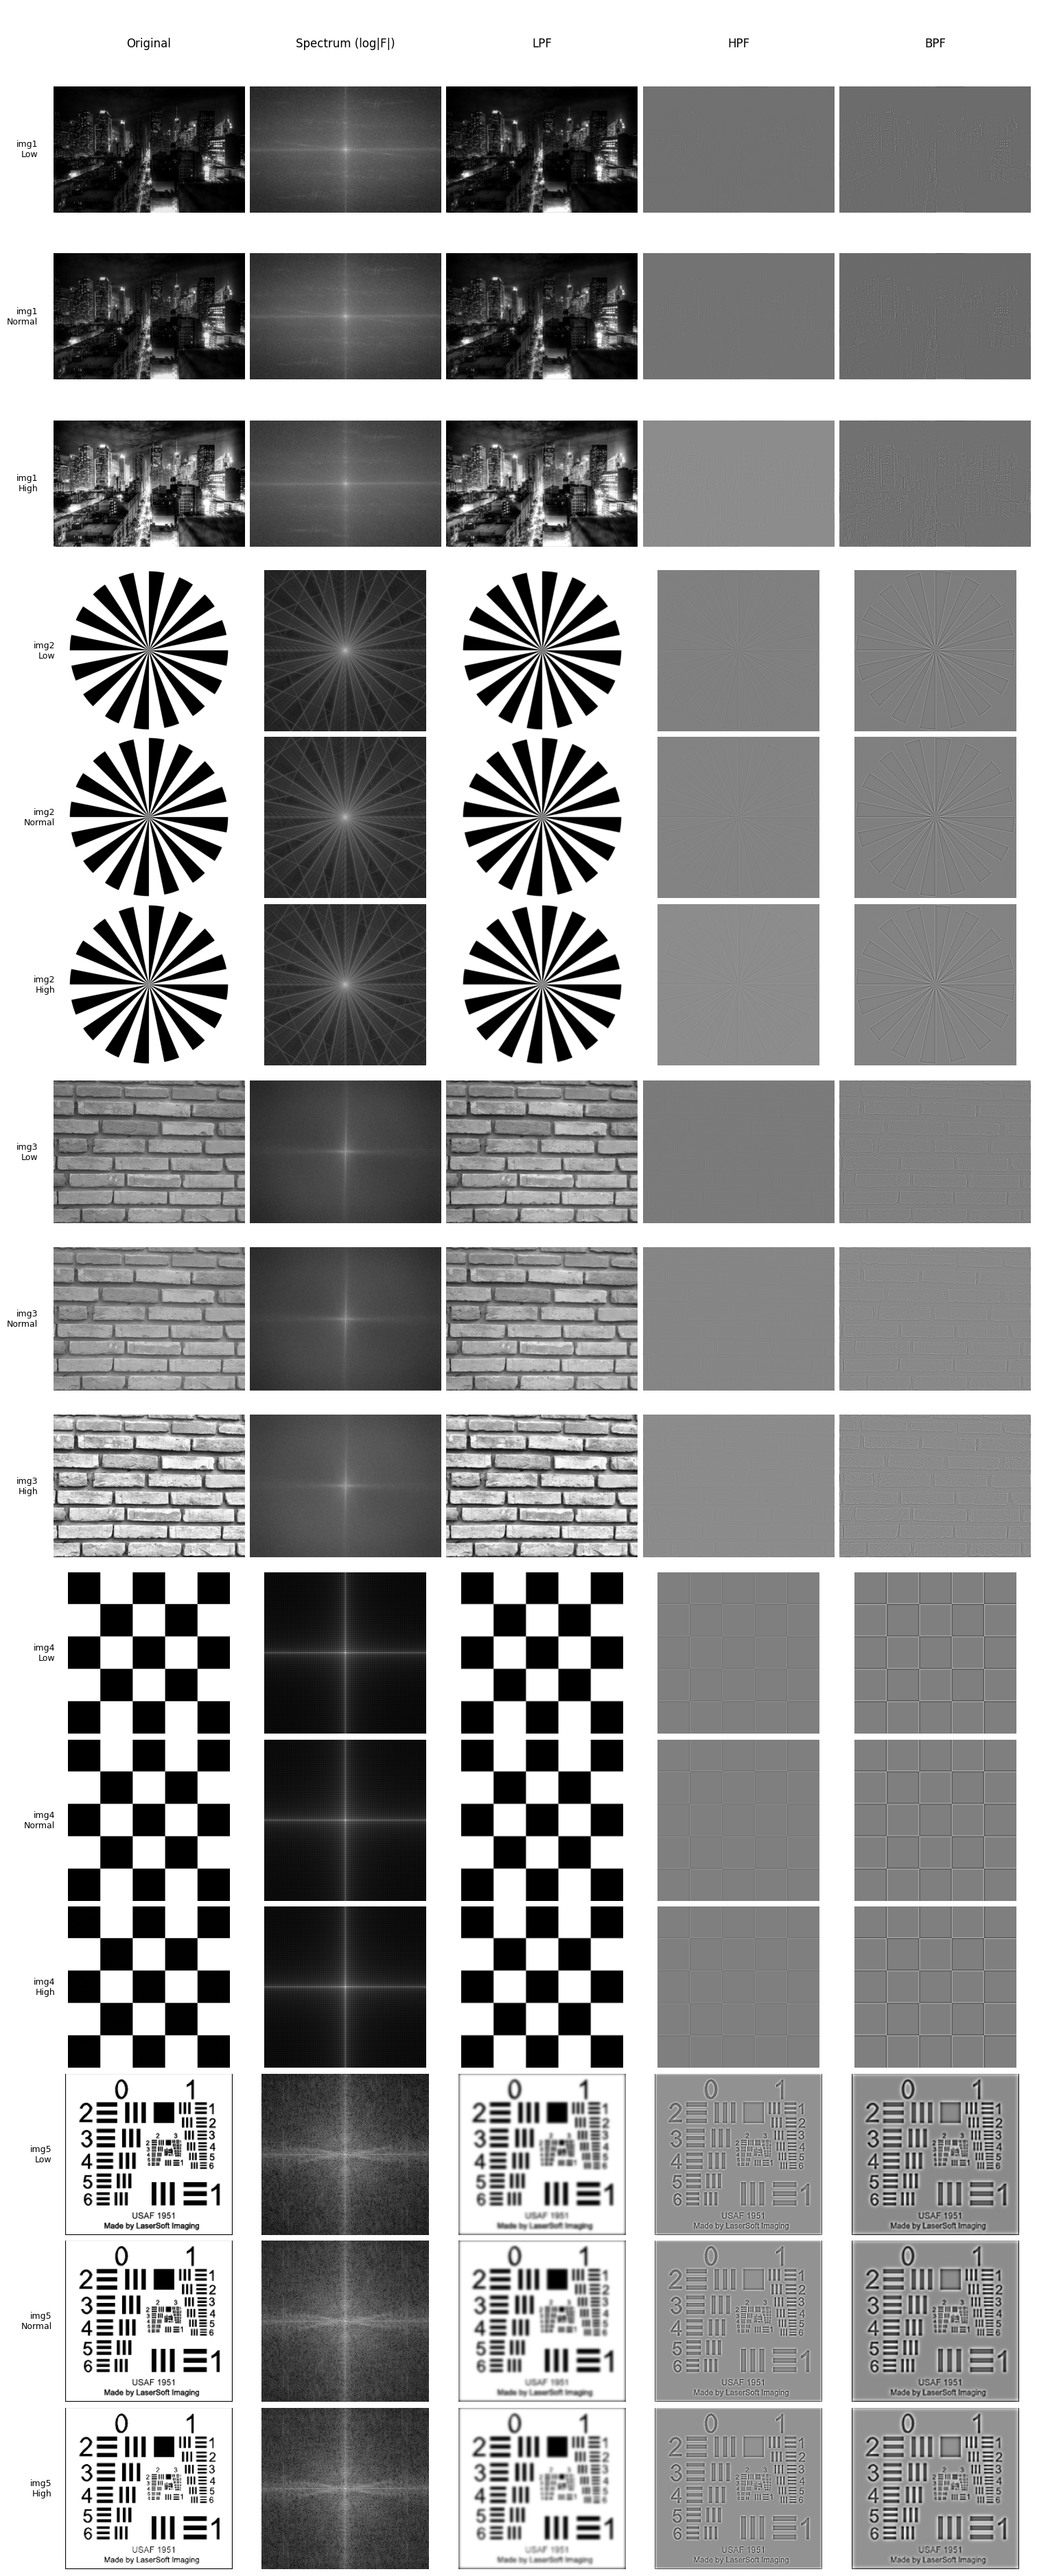

In [1]:
import glob, os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

# ---------------- Contrast helpers ----------------
def to_gray_float01(img_bgr):
    if img_bgr.ndim == 3:
        g = cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY)
    else:
        g = img_bgr
    g = g.astype(np.float32)
    g = (g - g.min()) / max(1e-6, (g.max() - g.min()))
    return g

def linear_contrast(x01, alpha=1.0, beta=0.0):
    return np.clip(alpha * x01 + beta, 0.0, 1.0)

def gamma_contrast(x01, gamma=1.0):
    x = np.clip(x01, 0, 1)
    return np.power(x, gamma)

def clahe_contrast(x01, clip=2.0, tile=(8,8)):
    x8 = np.uint8(np.clip(x01*255, 0, 255))
    y8 = cv.createCLAHE(clipLimit=clip, tileGridSize=tile).apply(x8)
    return y8.astype(np.float32) / 255.0

def make_contrast_versions(x01):
    low  = linear_contrast(gamma_contrast(x01, gamma=1.2), alpha=0.7)
    norm = x01.copy()
    high = linear_contrast(clahe_contrast(x01, clip=2.0), alpha=1.2)
    return low, norm, high

# ---------------- FFT helpers ----------------
def fft2c(x):      return np.fft.fftshift(np.fft.fft2(x))
def ifft2c(X):     return np.fft.ifft2(np.fft.ifftshift(X))
def mag_spectrum(X): return np.log1p(np.abs(X))

# ---------------- Gaussian filters (odd/even safe) ----------------
def gaussian_lpf(shape, d0):
    H, W = shape
    u = np.arange(H) - (H // 2)
    v = np.arange(W) - (W // 2)
    V, U = np.meshgrid(v, u)
    D2 = U.astype(np.float32)**2 + V.astype(np.float32)**2
    d0 = max(float(d0), 1e-6)
    return np.exp(-D2 / (2.0 * d0**2))

def gaussian_hpf(shape, d0): return 1.0 - gaussian_lpf(shape, d0)

def gaussian_bpf(shape, d_low, d_high):
    d_low, d_high = sorted([float(d_low), float(d_high)])
    return np.clip(gaussian_lpf(shape, d_high) - gaussian_lpf(shape, d_low), 0.0, 1.0)

# ---------------- Build rows for one image ----------------
def process_image_for_plot(gray01):
    low, norm, high = make_contrast_versions(gray01)
    variants = [("Low", low), ("Normal", norm), ("High", high)]
    rows_for_image = []
    for tag, img in variants:
        F = fft2c(img)
        spec = mag_spectrum(F)
        H, W = img.shape
        diag = np.hypot(H, W)
        g_lpf = gaussian_lpf((H, W), d0=diag*0.08)
        g_hpf = gaussian_hpf((H, W), d0=diag*0.10)
        g_bpf = gaussian_bpf((H, W), d_low=diag*0.05, d_high=diag*0.20)

        im_l = np.real(ifft2c(F * g_lpf))
        im_h = np.real(ifft2c(F * g_hpf))
        im_b = np.real(ifft2c(F * g_bpf))

        def norm01(a):
            a = a - a.min()
            m = a.max()
            return a / m if m > 1e-9 else a

        rows_for_image.append({
            "label": tag,
            "orig": norm01(img),
            "spectrum": norm01(spec),
            "LPF": norm01(im_l),
            "HPF": norm01(im_h),
            "BPF": norm01(im_b),
        })
    return rows_for_image

# ---------------- Main (Colab minimal uploader added) ----------------
def main():
    # ---- Minimal Colab upload: pick up to 5 images into ./images ----
    from google.colab import files
    os.makedirs("images", exist_ok=True)
    uploaded = files.upload()                   # choose files
    for i, (fn, data) in enumerate(uploaded.items()):
        if i >= 5: break
        with open(os.path.join("images", fn), "wb") as f:
            f.write(data)

    paths = sorted(glob.glob("images/*.*"))[:5]

    all_rows = []
    for p in paths:
        bgr = cv.imread(p, cv.IMREAD_COLOR)
        g01 = to_gray_float01(bgr)
        all_rows.append((os.path.splitext(os.path.basename(p))[0],
                         process_image_for_plot(g01)))

    nrows = len(all_rows) * 3
    ncols = 5
    fig = plt.figure(figsize=(ncols*3.0, (nrows+0.6)*2.4), constrained_layout=True)
    gs = fig.add_gridspec(nrows=nrows+1, ncols=ncols, height_ratios=[0.35]+[1.0]*nrows)

    # header row
    for j, t in enumerate(["Original","Spectrum (log|F|)","LPF","HPF","BPF"]):
        axh = fig.add_subplot(gs[0, j]); axh.axis("off")
        axh.text(0.5, 0.35, t, ha="center", va="center", fontsize=12)

    # image rows
    r = 0
    for name, rows_for_image in all_rows:
        for row in rows_for_image:
            for j, key in enumerate(["orig","spectrum","LPF","HPF","BPF"]):
                ax = fig.add_subplot(gs[r+1, j])
                ax.imshow(row[key], cmap="gray"); ax.axis("off")
                if j == 0:
                    ax.text(-0.08, 0.5, f"{name}\n{row['label']}",
                            ha="right", va="center", fontsize=9, transform=ax.transAxes)
            r += 1

    plt.show()

if __name__ == "__main__":
    main()
